# Street View House Numbers (SVHN)

* Author: Kevin Chuang [@k-chuang](https://www.github.com/k-chuang)
* Created on: September 14, 2018
* Description: Implementation of a deep neural network (CNN) using TensorFlow to recognize images of sequences of digits (Google's street view house numbers) 
* Dataset: [SVHN dataset](http://ufldl.stanford.edu/housenumbers/)

-----------

# Model Training Steps

1. Construction phase
    - Build static computational graph using TensorFlow
2. Execution phase
    - Initiate session to execute operations in the graph (e.g. as minimizing loss)

In [1]:
# OS packages
import os
import sys

# linear algebra
import numpy as np

# data processing 
import pandas as pd

# data visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# file system/structure 
import h5py

# deep learning framework
import tensorflow as tf

# time packages
import time
from datetime import timedelta

# utils
from sklearn.utils import shuffle

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

tf.logging.set_verbosity(tf.logging.INFO)

print("Tensorflow version: " + tf.__version__)

c:\users\kevin\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tensorflow version: 1.9.0


# Load data

- Load the preprocessed data from the previous notebook using `h5py`
- Save all the image attributes to use later

In [2]:
# Open the HDF5 file containing the datasets
with open(h5py.File('data/SVHN_multi_digit_norm_grayscale.h5','r')) as h5f:
    X_train = h5f['X_train'][:]
    y_train = h5f['y_train'][:]
    X_val = h5f['X_val'][:]
    y_val = h5f['y_val'][:]
    X_test = h5f['X_test'][:]
    y_test = h5f['y_test'][:]


print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_val.shape, y_val.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (225754, 32, 32, 1) (225754, 5)
Validation set (10000, 32, 32, 1) (10000, 5)
Test set (13068, 32, 32, 1) (13068, 5)


In [3]:
# Get the image data information & dimensions
train_count, img_height, img_width, num_channels = X_train.shape

# Get label information
num_digits, num_labels = y_train.shape[1], len(np.unique(y_train))

# Helper Functions

- Create helper functions to make notebook easier to read and reduce code duplication
    - Helper functions include plotting, initializing variables in TF graph, designing model, etc.

### Plot Images

In [4]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Helper function for plotting nrows * ncols images
    """
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 2*nrows))
    for i, ax in enumerate(axes.flat): 
        # Pretty string with actual label
        true_number = ''.join(str(x) for x in cls_true[i] if x != 10)
        if cls_pred is None:
            title = "Label: {0}".format(true_number)
        else:
            # Pretty string with predicted label
            pred_number = ''.join(str(x) for x in cls_pred[i] if x != 10)
            title = "Label: {0}, Pred: {1}".format(true_number, pred_number)  
            
        if images[i].shape == (32, 32, 3):
            ax.imshow(images[i])
        else:
            ax.imshow(images[i,:,:,0], cmap="gray")
        ax.set_title(title)   
        ax.set_xticks([]); ax.set_yticks([])

### Create new variables & initialization

- Create new Tensorflow variables with a given shape
- Initialize according to [Xavier & Glorot](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization scheme
    - will experiment with the [He](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf) intialization scheme as well
- Things to note:
    - The idea under both Xavier and He initialization is to preserve variance of activation values between layers.
    - `xavier_initializer_conv2d()` is the same as `xavier_initializer()`
        - just an alias to differentiate
    - `He` initialization is supposedly good for ReLu functions

In [5]:
def init_conv_weights_xavier(shape, name):
    return tf.get_variable(name, shape, initializer=tf.contrib.layers.xavier_initializer_conv2d())

def init_fc_weights_xavier(shape, name):
    return tf.get_variable(name, shape, initializer=tf.contrib.layers.xavier_initializer())

def init_conv_weights_he(shape, name):
    return tf.get_variable(name, shape, initializer=tf.keras.initializers.he_uniform())

def init_fc_weights_he(shape, name):
    return tf.get_variable(name, shape, initializer=tf.keras.initializers.he_uniform())

def init_biases(shape):
    return tf.Variable(tf.constant(0.0, shape=shape))

## Create layers in neural network

- Create functions for different layers in the computational graph our neural network in TensorFlow.
- Overview:
    - Convolution layer
    - Flatten layer
    - Fully connected or Dense layer

### Convolution Layer

- Convolution layers usually create feature maps of each indvidual image by convolving a fixed size filter across the image
- Conv layers will create abstract representations of the image 
    - The early layers will detect low level features, such as edges or blobs
    - The later layers will start learning high level features from the combination of low features in the earlier layers
- Convolution layers are usually used in image feature extraction, because they are shift invariant and can recognize small patterns in subsamples of an image

Common ConvNet architectures follows the pattern:

`INPUT > [[CONV -> RELU]*N -> POOL?]*M -> [FC -> RELU]*K -> FC`

Source: http://cs231n.github.io/convolutional-networks/

### Batch Normalization (Used)

- BN reduces the amount by what the hidden unit values shift around (covariance shift)
- BN allows each layer of a network to learn by itself a little bit more independently of other layers
- BN allows us to use higher learning rates, and controls exploding & vanishing gradients
- BN can also help reduce overfitting, with slight regularization effects
    - Similiar to dropout, it adds some noise to each hidden layer's activations.
    - We will still use dropout layers, but will use less dropout, thus keeping more information.
- How does BN work?
    - To increase stability of a neural network, BN normalizes the output of a previous activation layer by subtracting the batch mean and dividng by the batch standard deviation
    
Source: [Batch Normalization in Neural Networks](https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c)

### Maxout Layer (Not Used)

- A maxout layer is simply a layer where the activation function is the max of the inputs. 
- As stated in the paper (below), even an MLP with 2 maxout units can approximate any function.
- Similiar to ReLU (no saturation, linear regime of operation), and does not have its drawbacks of dying ReLU (or dying/vanishing gradients)

Source: [Maxout Network](https://arxiv.org/pdf/1302.4389v4.pdf)

In [6]:
def conv_layer(input_tensor,    # The input or previous layer
                filter_size,    # Width and height of each filter
                in_channels,    # Number of channels in previous layer
                num_filters,    # Number of filters
                layer_name,     # Layer description name
                pooling,        # Average pooling
                initializer='xavier'):   # He or Xavier initialization    
    
    # Add layer name scopes for better graph visualization
    with tf.name_scope(layer_name):
    
        # Shape of the filter-weights for the convolution
        shape = [filter_size, filter_size, in_channels, num_filters]

        # Create weights and biases
        if initializer == 'he':
            weights = init_conv_weights_he(shape, layer_name + '/weights')
        else:
            weights = init_conv_weights_xavier(shape, layer_name + '/weights')
    
        biases = init_biases([num_filters])
        
        # Add histogram summaries for weights
        tf.summary.histogram(layer_name + '/weights', weights)
        
        # Create the TensorFlow operation for convolution, with S=1 and zero padding
        activations = tf.nn.conv2d(input_tensor, weights, [1, 1, 1, 1], 'SAME') + biases
        
        # Add Batch Normalization
        activations = tf.layers.batch_normalization(activations)

        # Rectified Linear Unit (ReLU)
#         activations = tf.nn.relu(activations)
        activations = tf.nn.leaky_relu(activations, alpha=0.10)
#         activations = tf.contrib.layers.maxout(activations, num_units=num_filters)

        # pooling layer
        if pooling:
            # Create a pooling layer with F=2, S=1 and zero padding
#             activations = tf.nn.max_pool(activations, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
            activations = tf.nn.avg_pool(activations, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')

        return activations

### Flatten Layer

- A convolutional layer produces an output tensor with 4 dimensions.
    - (Batch_size, height, width, channels) or NHWC format
- A dense or fully connected layer will typically be added after convolution layers, and these layers can only take in 2-dim tensors. 
    - Need to reduce the 4-dim tensor to 2-dim, or flatten the (height, width, channels) axes 
- Example: 
    - `Input shape`: (?, 16, 16, 64) ---> `Flatten Layer` ---> `Output shape`: (?, 16 x 16 x 64) or (?, 16384).

In [7]:
def flatten_layer(input_tensor):
    """ Helper function for transforming a 4D tensor to 2D
    """
    # Get the shape of the input_tensor.
    input_tensor_shape = input_tensor.get_shape()

    # Calculate the volume of the input tensor
    num_activations = input_tensor_shape[1:4].num_elements()
    
    # Reshape the input_tensor to 2D: (?, num_activations)
    input_tensor_flat = tf.reshape(input_tensor, [-1, num_activations])

    # Return the flattened input_tensor and the number of activations
    return input_tensor_flat, num_activations

### Fully Connected (Dense) Layer

- Neurons in a fully connected layer have full connections to all activations in the previous layer (Perceptron)
- Their activations can hence be computed with a matrix multiplication followed by a bias offset.
- Then, they can this can be passed through an optional leaky ReLU function

In [8]:
def fc_layer(input_tensor,  # The previous layer,         
             input_dim,     # Num. inputs from prev. layer
             output_dim,    # Num. outputs
             layer_name,    # The layer name
            relu=False):    

    # Add layer name scopes for better graph visualization
    with tf.name_scope(layer_name):
    
        # Create new weights and biases.
        weights = init_fc_weights_xavier([input_dim, output_dim], layer_name + '/weights')
#         weights = init_fc_weights_he([input_dim, output_dim], layer_name + '/weights')

        biases = init_biases([output_dim])
        
        # Add histogram summaries for weights
        tf.summary.histogram(layer_name + '/weights', weights)

        # Calculate the layer activation
        activations = tf.matmul(input_tensor, weights) + biases
        
        if relu:
            activations = tf.nn.leaky_relu(activations, alpha=0.10)
#             activations = tf.nn.relu(activations)
#             activations = tf.contrib.layers.maxout(activations, num_units=output_dim)

        return activations

# TensorFlow Model

- Initialize the configurations of the CNN and the data dimensions. 
- Create placeholder variables (input variables, dropout)
- Create model architecture / computational graph
- Define loss function
- Define optimization method
- Define evaluation metric

In [9]:
# Optimizer learning rate
# learning_rate = 0.0001

# Conv Block 1
filter_size1 = filter_size2 = 5          
num_filters1 = num_filters2 = 32        

# Conv Block 2

filter_size3 = filter_size4 = 5          
num_filters3 = num_filters4 = 64

# Conv Block 3
filter_size5 = filter_size6 = filter_size7 = 5          
num_filters5 = num_filters6 = num_filters7 = 128  

# Fully-connected layers
fc1_size = fc2_size = 256

## Placeholder variables

In [10]:
with tf.name_scope("input"):
    
    # Placeholders for feeding input images
    x = tf.placeholder(tf.float32, shape=(None, img_height, img_width, num_channels), name='x')
    y_ = tf.placeholder(tf.int64, shape=[None, num_digits], name='y_')

with tf.name_scope("dropout"):
    
    # Dropout rate applied after the pooling layers
    p_keep_1 = tf.placeholder(tf.float32)
    tf.summary.scalar('conv_keep_probability', p_keep_1)

    # Dropout rate using between the fully-connected layers
    p_keep_2 = tf.placeholder(tf.float32)
    tf.summary.scalar('fc_keep_probability', p_keep_2)

## Model Definition

- The architecture of my model can be summarized as:



In [11]:
# Conv Block 1
conv_1 = conv_layer(x, filter_size1, num_channels, num_filters1, "conv_1", pooling=False)
conv_2 = conv_layer(conv_1, filter_size2, num_filters1, num_filters2, "conv_2", pooling=True)
drop_block1 = tf.nn.dropout(conv_2, p_keep_1) # Dropout

# Conv Block 2
conv_3 = conv_layer(conv_2, filter_size3, num_filters2, num_filters3, "conv_3", pooling=False)
conv_4 = conv_layer(conv_3, filter_size4, num_filters3, num_filters4, "conv_4", pooling=True)
drop_block2 = tf.nn.dropout(conv_4, p_keep_1) # Dropout

# Conv Block 3
conv_5 = conv_layer(drop_block2, filter_size5, num_filters4, num_filters5, "conv_5", pooling=False)
conv_6 = conv_layer(conv_5, filter_size6, num_filters5, num_filters6, "conv_6", pooling=False)
conv_7 = conv_layer(conv_6, filter_size7, num_filters6, num_filters7, "conv_7", pooling=True)
flat_tensor, num_activations = flatten_layer(tf.nn.dropout(conv_7, p_keep_2)) # Dropout

# Fully-connected 1
fc_1 = fc_layer(flat_tensor, num_activations, fc1_size, 'fc_1', relu=True)
drop_fc2 = tf.nn.dropout(fc_1, p_keep_2) # Dropout

# Fully-connected 2
fc_2 = fc_layer(drop_fc2, fc1_size, fc2_size, 'fc_2', relu=True)

# Parallel softmax layers
logits_1 = fc_layer(fc_2, fc2_size, num_labels, 'softmax1')
logits_2 = fc_layer(fc_2, fc2_size, num_labels, 'softmax2')
logits_3 = fc_layer(fc_2, fc2_size, num_labels, 'softmax3')
logits_4 = fc_layer(fc_2, fc2_size, num_labels, 'softmax4')
logits_5 = fc_layer(fc_2, fc2_size, num_labels, 'softmax5')

# Stack the logits together to make a prediction for an image (5 digit sequence prediction)
y_pred = tf.stack([logits_1, logits_2, logits_3, logits_4, logits_5])

# The class-number is the index of the largest element
y_pred_cls = tf.transpose(tf.argmax(y_pred, axis=2))

## Loss Function

- Calculate the loss by taking the average loss of every individual example for each of our 5 digits and adding them together. 
- Using `tf.nn.sparse_softmax_cross_entropy_with_logits` allows us to skip using `OneHotEncoding` on our label values.

In [12]:
with tf.name_scope('loss'):
    
    # Calculate the loss for each individual digit in the sequence
    loss1 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_1, labels=y_[:, 0]))
    loss2 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_2, labels=y_[:, 1]))
    loss3 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_3, labels=y_[:, 2]))
    loss4 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_4, labels=y_[:, 3]))
    loss5 = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_5, labels=y_[:, 4]))

    # Calculate the total loss for all predictions
    loss = loss1 + loss2 + loss3 + loss4 + loss5
    
    # Create tensorboard logs for loss
    tf.summary.scalar('loss', loss)

## Optimizer

- We have a loss function that must be minimized, now we need an optimizer to optimize on this loss function.
- `Adam` is a good starting optimizer historically & empirically
    - replacement of Stochastic Gradient Descent
    - adaptively changes the learning rate
        - maintains an adaptive per parameter learning rate that is based on the average of the first moment of the gradients (mean) and the second moment of the gradients (uncentered variance) 
- In addition to using the Adam optimizer, we also exponentially decay the learning rate by half (or 0.5) every 20 epochs
    - ~440 steps per epoch for batch size 512, so ~8800 steps for 20 epochs
    - Very useful & effective to decay the learning rate to prevent overshooting the optimal loss & overfitting 

In [13]:
with tf.name_scope('optimizer'):
    
    # Global step is required to compute the decayed learning rate
    global_step = tf.Variable(0, name='global_step', trainable=False)

    # Drop learning rate by half every 20 epochs
    decay_step = 8800
    
    # Apply exponential decay to the learning rate
    learning_rate = tf.train.exponential_decay(1e-3, global_step, decay_step, 0.5, staircase=True)

    # Add scalar summary for learning rate (for Tensorboard)
    tf.summary.scalar('learning_rate', learning_rate)

    # Construct a new Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

## Evaluation Metric

- To evaluate the performance of our model, we calculate the average accuracy across all samples
- To explain further:
    - `correct_prediction` is defined as the number of correctly classified sequences (if one digit is wrong in sequence, the whole prediction is incorrect)
        - First, we check if the batch of predictions & class labels are equal (`tf.equal` produces boolean tensors), and then cast it to a float data type (False -> 0.0, True -> 1.0)
            - **A correctly classified image would have a tensor of all 1's**
            - **An incorrectly classified image would have be a tensor with at least one 0.**
        - Then, we get the minimum value in each of the boolean tensors by using the `tf.reduce_min` function.
            - **A correctly classified image would have an output tensor minimum of 1**
            - **An incorrectly classified image would have an output tensor minimum of 0**
        - Finally, we calculate the mean of the `correct_prediction` tensor by summing up the 1's & 0's produced in `correct_prediction` & dividing by the total number of samples & multiplying by 100 to get a percentage.

In [14]:
with tf.name_scope("accuracy"):
    
    # Correct prediction is when predicted class equals the true class of each image
    correct_prediction = tf.reduce_min(tf.cast(tf.equal(y_pred_cls, y_), tf.float32), 1)

    # Cast predictions to float and calculate the mean
    accuracy = tf.reduce_mean(correct_prediction) * 100.0
    
    # Add scalar summary for accuracy tensor for accuracy
    tf.summary.scalar('accuracy', accuracy)

# Tensorflow Run

- Once TF graph has been created, we have to create a TensorFlow session which is used to execute the graph.
- Then, to save time from training again, we will initialize checkpoints 

In [15]:
# Launch the graph in a session
session = tf.Session()

## Checkpoints & TensorBoard

- Use checkpoints to save variables of the neural network
    - Can be reloaded quickly without having to train the network again
    - Create a Saver-object which is used for storing and retrieving all the variables of the TensorFlow graph.
- Write the TensorBoard summaries using the `tf.summary.FileWriter` class. 
    - Create two separate log files one for the training set and one for the validation set

In [16]:
SVHN_VERSION = 'svhn_v16'
CHECKPOINT_PATH = os.path.join('checkpoints', SVHN_VERSION)
LOG_DIR = os.path.join('logs', SVHN_VERSION)

if not os.path.exists(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)

In [17]:
saver = tf.train.Saver()

# Let's try to find the latest checkpoint - if any
try:
    print("Attempting to restore from last checkpoint ...")
    
    # Finds the filename of latest saved checkpoint file
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=CHECKPOINT_PATH)

    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)
    print("Restored checkpoint from:", last_chk_path)
    
# If the code above runs into an exception - initialize all the variables
except:
    print("Failed to restore checkpoint - initializing variables")
    session.run(tf.global_variables_initializer())


Restoring last checkpoint ...
Failed to restore checkpoint - initializing variables


In [18]:
# Merge all the summaries and write them out to LOG_DIR
merged = tf.summary.merge_all()

# Pass the graph to the writer to display it in TensorBoard
train_writer = tf.summary.FileWriter(LOG_DIR + '/train', session.graph)
validation_writer = tf.summary.FileWriter(LOG_DIR + '/validation')

# Model Training

- Initialize neural network hyperparameters
    - batch size
    - dropout
    - epoch size
    - display size
- Things I learned:
    - `tf.nn.dropout` uses a keep_prob, so this is the percentage of connections to keep, not drop out rate (unlike `tf.layers.dropout` and the Keras `Dropout` layer.
- Reasoning for dropout layers
    - Increase regularization to decrease overfitting of deep neural network
    - Since we have batch normalization in convolutional layers, which has regularization effects, we will drop less of the convolutional layers
    - Keep dropout at fully connected layers higher (since no regularization occurs there)

In [19]:
# Epoch size
epochs = 20

# Display step to print out & for writing to tensorboard (put together for now)
display_step = 200

# Batch size
batch_size = 512

# Dropout applied between the conv layers (This is keep probability not dropout rate)
d1 = 0.50

# Dropout applied to the fully-connected layers
d2 = 0.50

### Batch Data Generator

- In each iteration, a new batch of data is selected from the training set
    - In our case a new batch of 512 images will be selected (comes out to around 440 iterations to run through whole dataset)
- `feed_dict` function (Used in training, evaluating, and making predictions)
    - will return a batch of the data based on batch_size & step
    - **AND IMPORTANT**, at every epoch (when step is 0) it will shuffle the data
- `evaluate_batch` function (Used in training)
    - will split the validation and test set into batches and calculates the accuracy over all of the batches.
- `get_batch` function  (Not used)
    - is not directly used, but could also be used further to save on memory (Python `generator`)

In [20]:
def get_batch(X, y, batch_size=512):
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])


def feed_dict(X, y, step=0):
    """ Make a TensorFlow feed_dict mapping data onto the placeholders
    """
    
#     # Shuffle the data after every epoch so the algorithm doesn't seem the same order every epoch
    if step == 0:
        print('Shuffling data after each epoch....')
        X, y = shuffle(X, y)
        
    # Calculate the offset
    offset = (step * batch_size) % (y.shape[0] - batch_size)
    
    # Get the batch data
    xs, ys = X[offset:offset + batch_size], y[offset:offset+batch_size]
        
    return {x: xs, y_: ys, p_keep_1: d1, p_keep_2: d2}


def evaluate_batch(test, batch_size):
    """ Evaluate in batches 
    """
    # Store the cumulative accuracy over all batches
    cumulative_accuracy = 0.0
    
    # Get the number of images
    n_images = y_test.shape[0] if test else y_val.shape[0]
    
    # Numer of batches needed to evaluate all images
    n_batches = n_images // batch_size + 1
    
    # Iterate over all the batches
    for i in range(n_batches):
        
        # Calculate the offset
        offset = i * batch_size
     
        if test:
            # Get the batch from the test set
            xs, ys = X_test[offset:offset+batch_size], y_test[offset:offset+batch_size]
        else:
            # Get batch from the validation set
            xs, ys = X_val[offset:offset+batch_size], y_val[offset:offset+batch_size]
            
        cumulative_accuracy += session.run(accuracy,
                {x: xs, y_: ys, p_keep_1: 1.0, p_keep_2: 1.0})
                                           
    # Return the average accuracy over all batches
    return cumulative_accuracy / float(n_batches)

In [21]:
def train_model(max_epochs, display_step, batch_size, total_train):
    
    # To calculate total time of training
    start_time = time.time()
    
    # Calculate the number of steps based on total number of training data & batch size:
    num_of_iterations = total_train // batch_size + 1
    
    for epoch in range(max_epochs):
        print('=====================================================')
        print('Epoch', epoch+1 , ':')
        print('=====================================================')
        
        for step in range(num_of_iterations):
            train_acc, summary, i,  _ = session.run([accuracy, merged, global_step, optimizer], 
                                        feed_dict=feed_dict(X_train, y_train, step))
            train_writer.add_summary(summary, i)

            if(step % display_step == 0) or (step == num_of_iterations - 1):
                
                # Display the minibatch accuracy
                print("Minibatch accuracy at step %d: %.4f" % (i, train_acc))
                
                val_summary, val_acc= session.run([merged, accuracy], 
                                        feed_dict={x: X_val, y_: y_val, p_keep_1: 1.0, p_keep_2: 1.0})

                print("Validation accuracy at step %d: %.4f" % (i, val_acc))
                validation_writer.add_summary(val_summary, i)

        
       # Calculate the accuracy on the validation-set after epoch is done
        valid_acc = evaluate_batch(test=False, batch_size=batch_size)
        print("Validation accuracy after epoch %i: %.4f" % (epoch+1, valid_acc))
        
        print ('Epoch', epoch+1, 'completed out of', max_epochs)

    
        # Calculate net time
        time_diff = time.time() - start_time
        print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
        
       # Calculate and display the testset accuracy
        test_acc = evaluate_batch(test=True, batch_size=batch_size)
        print("Test accuracy: %.4f" % test_acc)
        
        # Save all the variables of the TensorFlow graph
        saver.save(session, save_path= os.path.join(CHECKPOINT_PATH, SVHN_VERSION), global_step=global_step)
        print('Model saved in file: {}'.format(os.path.join(CHECKPOINT_PATH, SVHN_VERSION)))
        
        print('=====================================================')
        print()
    
    print()
    print("Final test accuracy: %.4f" % test_acc)
    # Calculate total time
    total_time = time.time() - start_time
    print("Total time usage: " + str(timedelta(seconds=int(round(total_time)))))

In [22]:
train_model(max_epochs=20, display_step=200, batch_size=512, total_train=train_count)

Epoch 1 :
Shuffling data after each epoch....
Validation accuracy at step 1: 1.5800
Validation accuracy at step 201: 6.7800
Validation accuracy at step 401: 49.5400
Validation accuracy at step 441: 54.2800
Validation accuracy after epoch 1: 54.1108
Epoch 1 completed out of 20
Time usage: 0:00:59
Test accuracy: 59.6927
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 2 :
Shuffling data after each epoch....
Validation accuracy at step 442: 54.2700
Validation accuracy at step 642: 69.7600
Validation accuracy at step 842: 75.9700
Validation accuracy at step 882: 75.7100
Validation accuracy after epoch 2: 75.7623
Epoch 2 completed out of 20
Time usage: 0:01:56
Test accuracy: 79.9403
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 3 :
Shuffling data after each epoch....
Validation accuracy at step 883: 75.5900
Validation accuracy at step 1083: 79.8500
Validation accuracy at step 1283: 81.1100
Validation accuracy at step 1323: 81.5700
Validation accuracy after epoch 3: 81.6

Validation accuracy at step 6616: 89.3000
Validation accuracy at step 6816: 88.9200
Validation accuracy at step 7016: 88.3700
Validation accuracy at step 7056: 88.8500
Validation accuracy after epoch 16: 88.9390
Epoch 16 completed out of 20
Time usage: 0:15:15
Test accuracy: 91.9688
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 17 :
Shuffling data after each epoch....
Validation accuracy at step 7057: 88.9000
Validation accuracy at step 7257: 89.2900
Validation accuracy at step 7457: 88.9600
Validation accuracy at step 7497: 89.6800
Validation accuracy after epoch 17: 89.7926
Epoch 17 completed out of 20
Time usage: 0:16:12
Test accuracy: 92.3205
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 18 :
Shuffling data after each epoch....
Validation accuracy at step 7498: 89.4800
Validation accuracy at step 7698: 89.3200
Validation accuracy at step 7898: 88.9900
Validation accuracy at step 7938: 89.2400
Validation accuracy after epoch 18: 89.3026
Epoch 18 completed out

In [23]:
train_model(max_epochs=20, display_step=200, batch_size=512, total_train=train_count)

Epoch 1 :
Shuffling data after each epoch....
Validation accuracy at step 8821: 89.7300
Validation accuracy at step 9021: 90.4600
Validation accuracy at step 9221: 90.2300
Validation accuracy at step 9261: 90.7000
Validation accuracy after epoch 1: 90.7887
Epoch 1 completed out of 20
Time usage: 0:00:56
Test accuracy: 93.3401
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 2 :
Shuffling data after each epoch....
Validation accuracy at step 9262: 90.7400
Validation accuracy at step 9462: 90.3300
Validation accuracy at step 9662: 90.2300
Validation accuracy at step 9702: 90.4100
Validation accuracy after epoch 2: 90.4797
Epoch 2 completed out of 20
Time usage: 0:01:53
Test accuracy: 93.6795
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 3 :
Shuffling data after each epoch....
Validation accuracy at step 9703: 90.5100
Validation accuracy at step 9903: 90.3700
Validation accuracy at step 10103: 90.4200
Validation accuracy at step 10143: 90.4100
Validation accuracy afte

Validation accuracy at step 15436: 90.7200
Validation accuracy at step 15636: 90.9800
Validation accuracy at step 15836: 90.9400
Validation accuracy at step 15876: 90.4900
Validation accuracy after epoch 16: 90.5664
Epoch 16 completed out of 20
Time usage: 0:15:13
Test accuracy: 93.4651
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 17 :
Shuffling data after each epoch....
Validation accuracy at step 15877: 90.6200
Validation accuracy at step 16077: 90.6900
Validation accuracy at step 16277: 90.6000
Validation accuracy at step 16317: 90.7700
Validation accuracy after epoch 17: 90.8485
Epoch 17 completed out of 20
Time usage: 0:16:10
Test accuracy: 93.4671
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 18 :
Shuffling data after each epoch....
Validation accuracy at step 16318: 90.8000
Validation accuracy at step 16518: 90.9300
Validation accuracy at step 16718: 90.4800
Validation accuracy at step 16758: 90.9300
Validation accuracy after epoch 18: 91.0133
Epoch 18 c

In [24]:
train_model(max_epochs=20, display_step=200, batch_size=512, total_train=train_count)

Epoch 1 :
Shuffling data after each epoch....
Validation accuracy at step 17641: 91.2000
Validation accuracy at step 17841: 91.2100
Validation accuracy at step 18041: 91.0300
Validation accuracy at step 18081: 91.1300
Validation accuracy after epoch 1: 91.2173
Epoch 1 completed out of 20
Time usage: 0:00:56
Test accuracy: 93.8052
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 2 :
Shuffling data after each epoch....
Validation accuracy at step 18082: 91.2800
Validation accuracy at step 18282: 91.2900
Validation accuracy at step 18482: 91.4900
Validation accuracy at step 18522: 91.2000
Validation accuracy after epoch 2: 91.2856
Epoch 2 completed out of 20
Time usage: 0:01:53
Test accuracy: 93.8878
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 3 :
Shuffling data after each epoch....
Validation accuracy at step 18523: 91.2200
Validation accuracy at step 18723: 91.2200
Validation accuracy at step 18923: 91.2100
Validation accuracy at step 18963: 90.9600
Validation acc

Validation accuracy at step 24256: 91.2200
Validation accuracy at step 24456: 91.2300
Validation accuracy at step 24656: 91.1000
Validation accuracy at step 24696: 91.2000
Validation accuracy after epoch 16: 91.2856
Epoch 16 completed out of 20
Time usage: 0:15:13
Test accuracy: 94.1111
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 17 :
Shuffling data after each epoch....
Validation accuracy at step 24697: 91.2500
Validation accuracy at step 24897: 90.9200
Validation accuracy at step 25097: 91.1300
Validation accuracy at step 25137: 91.1000
Validation accuracy after epoch 17: 91.1621
Epoch 17 completed out of 20
Time usage: 0:16:10
Test accuracy: 93.9042
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 18 :
Shuffling data after each epoch....
Validation accuracy at step 25138: 91.1700
Validation accuracy at step 25338: 91.2200
Validation accuracy at step 25538: 91.3100
Validation accuracy at step 25578: 91.2700
Validation accuracy after epoch 18: 91.3367
Epoch 18 c

In [25]:
train_model(max_epochs=20, display_step=200, batch_size=512, total_train=train_count)

Epoch 1 :
Shuffling data after each epoch....
Validation accuracy at step 26461: 91.3400
Validation accuracy at step 26661: 91.4700
Validation accuracy at step 26861: 91.4900
Validation accuracy at step 26901: 91.4500
Validation accuracy after epoch 1: 91.5298
Epoch 1 completed out of 20
Time usage: 0:00:56
Test accuracy: 94.3064
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 2 :
Shuffling data after each epoch....
Validation accuracy at step 26902: 91.4900
Validation accuracy at step 27102: 91.6700
Validation accuracy at step 27302: 91.3800
Validation accuracy at step 27342: 91.6100
Validation accuracy after epoch 2: 91.6774
Epoch 2 completed out of 20
Time usage: 0:01:53
Test accuracy: 94.3064
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 3 :
Shuffling data after each epoch....
Validation accuracy at step 27343: 91.6800
Validation accuracy at step 27543: 91.4600
Validation accuracy at step 27743: 91.3900
Validation accuracy at step 27783: 91.2800
Validation acc

Validation accuracy at step 33076: 91.5800
Validation accuracy at step 33276: 91.2600
Validation accuracy at step 33476: 91.7700
Validation accuracy at step 33516: 91.4100
Validation accuracy after epoch 16: 91.4735
Epoch 16 completed out of 20
Time usage: 0:15:13
Test accuracy: 94.2627
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 17 :
Shuffling data after each epoch....
Validation accuracy at step 33517: 91.3900
Validation accuracy at step 33717: 91.5100
Validation accuracy at step 33917: 91.3900
Validation accuracy at step 33957: 91.5200
Validation accuracy after epoch 17: 91.5809
Epoch 17 completed out of 20
Time usage: 0:16:11
Test accuracy: 94.2026
Model saved in file: checkpoints\svhn_v16\svhn_v16

Epoch 18 :
Shuffling data after each epoch....
Validation accuracy at step 33958: 91.6400
Validation accuracy at step 34158: 91.4600
Validation accuracy at step 34358: 91.5200
Validation accuracy at step 34398: 91.4100
Validation accuracy after epoch 18: 91.4821
Epoch 18 c

## Summary of training

- I ran the model through 80 epochs (or 80 complete run throughs of the whole training dataset), which only took about an hour (thanks to my NVIDIA 1070 GPU as well as CUDA & cuDNN)
- The test accuracy seems to grow more slowly and then fluctuate in later epochs 
    - Initially, it grows fast, then starts to increase very slowly
- **Could run for more epochs to potentially have mariginal gains**

# Model Evaluation

## Test set performance

- Predict test set & calculate accuracy based on predictions
- Remember to disable dropout during predictions & evaluations
    - Dropout is only applied in training
- Two types of evaluation:
    - Original Image evaluation (Multiple digits)
    - Individual Digit evaluation (Single digit)

### Original Image Evaluation (Multiple digits)

In [27]:
# Feed the test set with dropout disabled
test_feed_dict={
    x: X_test,
    y_: y_test,
    p_keep_1: 1.0,
    p_keep_2: 1.0
}

# Generate predictions for the testset
test_pred = session.run(y_pred_cls, feed_dict=test_feed_dict)

# Display the predictions
test_pred

array([[ 5, 10, 10, 10, 10],
       [ 1,  6, 10, 10, 10],
       [ 6,  1, 10, 10, 10],
       ...,
       [ 3, 10, 10, 10, 10],
       [ 2,  1, 10, 10, 10],
       [ 2, 10, 10, 10, 10]], dtype=int64)

In [28]:
test_pred.shape

(13068, 5)

In [29]:
def calculate_accuracy(a, b):
    """ Calculating the % of similar rows in two numpy arrays 
    """
    # Compare two numpy arrays row-wise
    correct = np.sum(np.all(a == b, axis=1))
    return 100.0 * (correct / float(a.shape[0]))


total_acc = calculate_accuracy(test_pred, y_test)

print('Multiple Digit Test Accuracy: %.3f %%' % total_acc)

Multiple Digit Test Accuracy: 94.399 %


### Individual Digit Evaluation

- Calculate the model's accuracy on each individual digit only counting the non missing values
- Plot confusion matrix to show performance of each class
    - Imbalanced classes, so using a confusion matrix is a better indicator of true performance
    - Calculate F1 score, which can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. 
        - F1 = 2 * (precision * recall) / (precision + recall)
        - In the multi-class case, this is the weighted average of the F1 score of each class.
        - F1 score is a good metric for measuring performances of models with imbalanced classes
    - Produce a classification report for each individual digit
        - Precision, recall, and F1 scores

In [30]:
from sklearn.metrics import accuracy_score

# Find the position of the non missing labels
non_zero = np.where(y_test.flatten() != 10)

# Calculate the accuracy on the individual digit level
ind_acc = accuracy_score(test_pred.flatten()[non_zero], y_test.flatten()[non_zero]) * 100.0

print('Individual Digit Test Accuracy: %.3f %%' % ind_acc)

Individual Digit Test Accuracy: 96.620 %


c:\users\kevin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


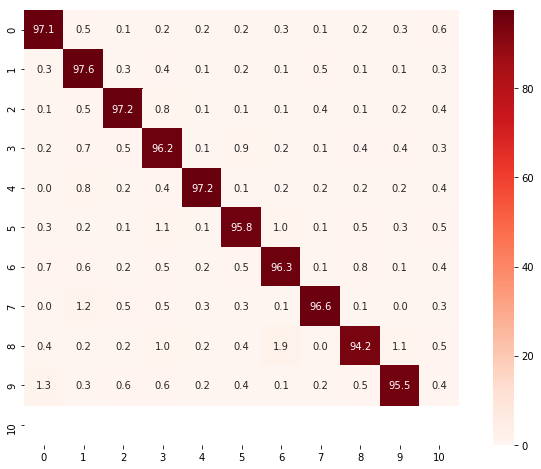

In [31]:
from sklearn.metrics import confusion_matrix

# Set the figure size
plt.figure(figsize=(12, 8))

# Calculate the confusion matrix
cm = confusion_matrix(y_test.flatten()[non_zero], test_pred.flatten()[non_zero])

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

In [32]:
from sklearn.metrics import f1_score

f1 = f1_score(test_pred.flatten()[non_zero], y_test.flatten()[non_zero], average='weighted')

print('Individual Digit F1 Score: %.4f' % f1)

Individual Digit F1 Score: 0.9643


c:\users\kevin\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
from sklearn.metrics import classification_report

cls_report = classification_report(test_pred.flatten()[non_zero], y_test.flatten()[non_zero], digits=4)
print(cls_report)

             precision    recall  f1-score   support

          0     0.9713    0.9565    0.9639      1771
          1     0.9761    0.9768    0.9765      5095
          2     0.9716    0.9834    0.9774      4099
          3     0.9622    0.9523    0.9572      2912
          4     0.9723    0.9847    0.9785      2491
          5     0.9581    0.9699    0.9639      2355
          6     0.9626    0.9572    0.9599      1988
          7     0.9658    0.9731    0.9694      2004
          8     0.9422    0.9583    0.9502      1632
          9     0.9549    0.9603    0.9576      1586
         10     0.0000    0.0000    0.0000        99

avg / total     0.9625    0.9662    0.9643     26032



c:\users\kevin\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Analysis

- It seems like the digits `8` and `3` seem to have the lowest f1-score
    - This maybe due to them being very similiar to each other and other digits at different angles and thus easily misclassified

## Number of digits per image 

- Let's see if the number of digits per image had an impact on the model's performance

In [34]:
# For every possible sequence length
for num_digits in range(1, 6):
    
    # Find all images with that given sequence length (returns an boolean array of True & Falses)
    images = np.where((y_test != 10).sum(1) == num_digits)
    
    # Calculate the accuracy on those images
    acc = calculate_accuracy(test_pred[images], y_test[images])
    
    print("%d digit accuracy %.3f %%" % (num_digits, acc))

1 digit accuracy 94.805 %
2 digit accuracy 95.010 %
3 digit accuracy 92.023 %
4 digit accuracy 87.671 %
5 digit accuracy 0.000 %


### Analysis

- Results:
    - The number of digits per image had a huge impact on model's performance. 0% of the 5 digit images were classified, and as the number of digits per image increased, there seems to be a decrease in accuracy.
    - This could be because of imbalanced classes, where there were not a lot of training data with 5 digits per image as shown in the exploration/preprocessing notebook [svhn-preprocessing.ipynb]().
        - With more 5 digit training images, we could potentially increase performance
    - This is also a downfall of the designed neural network, seeing that it is not very scale invariant. 
        - 5 digit images seem to be very tightly packed together vs. 1 digit images where the digit is scaled differently

## Visualization of images

- Correctly classified images
- Incorrectly classified images

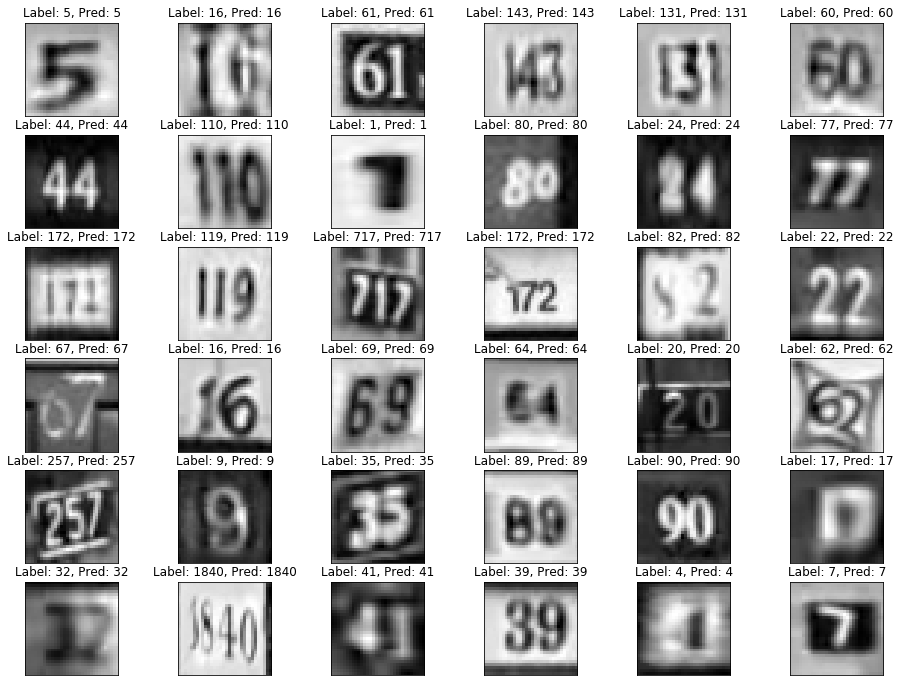

In [35]:
# Find the correctly classified examples
correct = np.array([(a==b).all() for a, b in zip(test_pred, y_test)])

# Select the incorrectly classified examples
images = X_test[correct]
cls_true = y_test[correct]
cls_pred = test_pred[correct]

# Plot the correctly- classified examples
plot_images(images, 6, 6, cls_true, cls_pred);

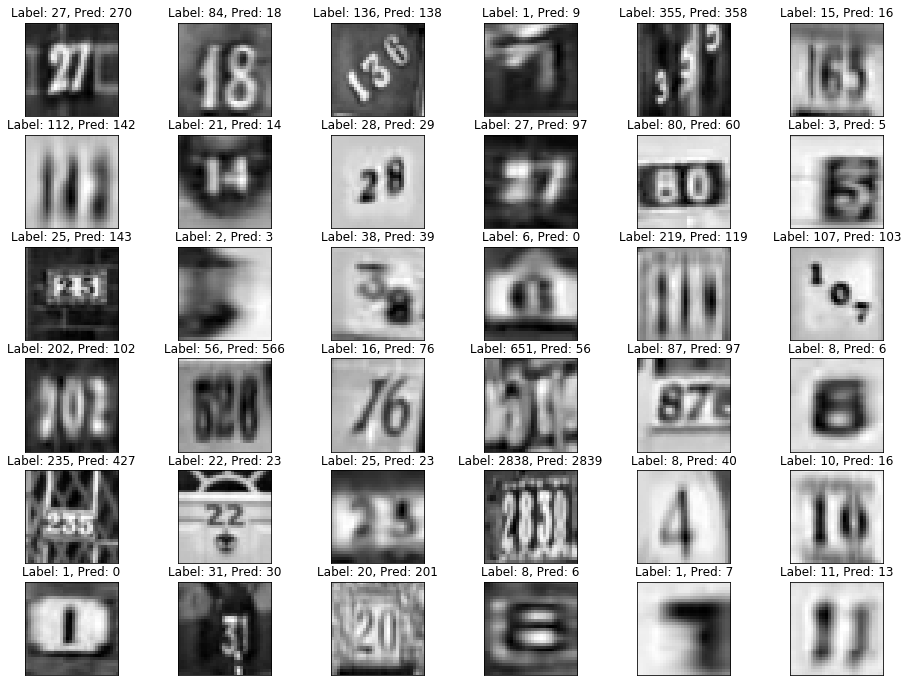

In [36]:
# Find the incorrectly classified examples
incorrect = np.invert(correct)

# Select the incorrectly classified examples
images = X_test[incorrect]
cls_true = y_test[incorrect]
cls_pred = test_pred[incorrect]

# Plot the mis-classified examples
plot_images(images, 6, 6, cls_true, cls_pred);

In [37]:
# End the Tensorflow Session
session.close()